# IV Rank Calculation

The IV rank, or Implied Volatility rank, is a metric used to check where the current implied volatility of a financial instrument stands relative to its recent trading history. It helps us assess whether the current implied volatility is high or low compared to past levels over a specified period. The IV rank can be computed using the formula: 

$$ IV ~Rank = \frac{Current ~IV - Minimum ~IV}{Maximum ~IV - Minimum ~IV} $$

Here Minimum IV and Maximum IV represent the minimum and maximum levels of implied volatility observed over the chosen period. In this notebook, we will calculate the IV rank of the ATM strike prices. 

The notebook is structured as follows:
1. [Read SPX Options Data](#read)
2. [Calculate the ATM Strike](#ATM)
3. [Data Pre-Processing](#pre)
4. [Compute the IV Rank](#rank)
5. [Conclusion](#conclusion)

## Import Libraries

In [1]:
# For data manipulation
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

<a id='read'></a>
## Read SPX Options Data

Read the file `spx_eom_expiry_options_2015_2023.bz2` using the `read_pickle` method of pandas. The file contains SPX options data for the period from 2015 to 2023. This bz2 file is available as a zip file.

In [2]:
# Load the dataset
data = pd.read_pickle("../data_modules/spx_eom_expiry_options_2015_2023.bz2")

# Removing columns not needed for IV rank computation
data = data.drop(columns=[' [STRIKE_DISTANCE_PCT]', ' [P_LAST]', ' [C_LAST]', ' [DTE]',
                          ' [C_GAMMA]', ' [C_VEGA]', ' [C_THETA]', ' [C_DELTA]', ' [P_DELTA]',
                          ' [P_GAMMA]', ' [P_VEGA]', ' [P_THETA]', ' [C_VOLUME]', ' [EXPIRE_DATE]',
                          ' [P_VOLUME]'])

# Display the last 5 rows of data
data.tail()

,[STRIKE],[UNDERLYING_LAST],[C_IV],[P_IV]
[QUOTE_DATE],,,,
2023-12-29,3905.0,4772.17,,1.333700
2023-12-29,3900.0,4772.17,,1.341460
2023-12-29,3895.0,4772.17,,1.349380
2023-12-29,3945.0,4772.17,,1.270100
2023-12-29,3350.0,4772.17,,2.271590


<a id='ATM'></a>
## Calculate the ATM strike

To calculate the IV rank we will focus on the ATM strikes. This is because ATM options reflect the current market sentiment and expectations due to their proximity to the underlying asset's price. They also typically exhibit the highest trading volume and liquidity, ensuring reliable and consistent IV data.

In [3]:
# Set the strike multiple
# This determines the interval at which strike prices are rounded

strike_multiple = 5

# Determine the ATM strike price
# Calculate the ATM strike price by rounding the last traded price of the underlying asset
# to the nearest multiple of the strike_multiple.
data['ATM'] = strike_multiple * \
    (round(data[' [UNDERLYING_LAST]'] / strike_multiple))

# Create an empty DataFrame to store the rows of ATM strike
atm_data = pd.DataFrame()

# Loop through the data grouped by date, processing each group separately.
for date, group in data.groupby(data.index):
    
    # Filter rows in the group where the strike price matches the calculated ATM strike price.
    filtered_row = group[group[' [STRIKE]'] == group['ATM']]
    
    # Append the filtered row to the atm_data DataFrame
    atm_data = atm_data.append(filtered_row)
    
# Display the data
atm_data.tail()

,[STRIKE],[UNDERLYING_LAST],[C_IV],[P_IV],ATM
[QUOTE_DATE],,,,,
2023-12-22,4755.0,4755.11,0.104570,0.088620,4755.0
2023-12-26,4775.0,4774.94,0.112520,0.091160,4775.0
2023-12-27,4780.0,4782.50,0.105270,0.079200,4780.0
2023-12-28,4785.0,4783.83,0.092410,0.079580,4785.0
2023-12-29,4770.0,4772.17,,0.021610,4770.0


<a id='pre'></a>
## Data Pre-Processing

We will strip any leading or trailing whitespace from the `[C_IV]` and `[P_IV]` columns to ensure that the data is clean and free of extraneous spaces that could interfere with subsequent operations. 

In [4]:
# Remove leading/trailing whitespace from [C_IV] and [P_IV]
atm_data[' [C_IV]'] = atm_data[' [C_IV]'].str.strip()
atm_data[' [P_IV]'] = atm_data[' [P_IV]'].str.strip()

We then replace empty strings and occurrences of 'NaN' with actual NaN values to standardise missing data. Converting the `[C_IV]` and `[P_IV]` columns to float is essential because numerical operations, such as summing these columns, require them to be in a numeric format.

In [5]:
# Replace empty strings and 'NaN' with actual NaN values
atm_data[' [C_IV]'] = atm_data[' [C_IV]'].replace(['', 'NaN'], np.nan)
atm_data[' [P_IV]'] = atm_data[' [P_IV]'].replace(['', 'NaN'], np.nan)

# Convert [C_IV] and [P_IV] columns to float type
atm_data[' [C_IV]'] = atm_data[' [C_IV]'].astype(float)
atm_data[' [P_IV]'] = atm_data[' [P_IV]'].astype(float)

The `ATM_IV` is computed by adding the values of `[C_IV]` and `[P_IV]` to obtain a total implied volatility for ATM options.

In [6]:
# Compute ATM_IV by taking the mean of [C_IV] and [P_IV]
atm_data['ATM_IV'] = (atm_data[' [C_IV]'] + atm_data[' [P_IV]'])/2

# Drop rows with NaN values
atm_data.dropna(inplace=True)

# Show the last few rows of atm_data
atm_data.tail()

,[STRIKE],[UNDERLYING_LAST],[C_IV],[P_IV],ATM,ATM_IV
[QUOTE_DATE],,,,,,
2023-12-21,4745.0,4747.03,0.10688,0.10432,4745.0,0.105600
2023-12-22,4755.0,4755.11,0.10457,0.08862,4755.0,0.096595
2023-12-26,4775.0,4774.94,0.11252,0.09116,4775.0,0.101840
2023-12-27,4780.0,4782.50,0.10527,0.07920,4780.0,0.092235
2023-12-28,4785.0,4783.83,0.09241,0.07958,4785.0,0.085995


<a id='rank'></a>
## Compute the IV Rank

We will calculate the IV rank for each day based on the historical distribution of ATM (At-The-Money) implied volatility (IV). 

1. First, we define a rolling window of `252` days, which represents a typical trading year. 
2. Next, for this window, we compute the minimum (`Rolling_Min`) and maximum (`Rolling_Max`) IV values observed over the preceding 252 days for each day in the dataset. These rolling minimum and maximum values serve as benchmarks to normalise the current day's ATM IV (`ATM_IV`) on a percentile scale relative to its recent historical range. 
3. The IV rank (`IV_Rank`) is then computed by determining where the current ATM IV falls within this range, expressed as a percentage. 

A higher IV rank indicates that the current IV is relatively high compared to its recent history and vice-versa. 

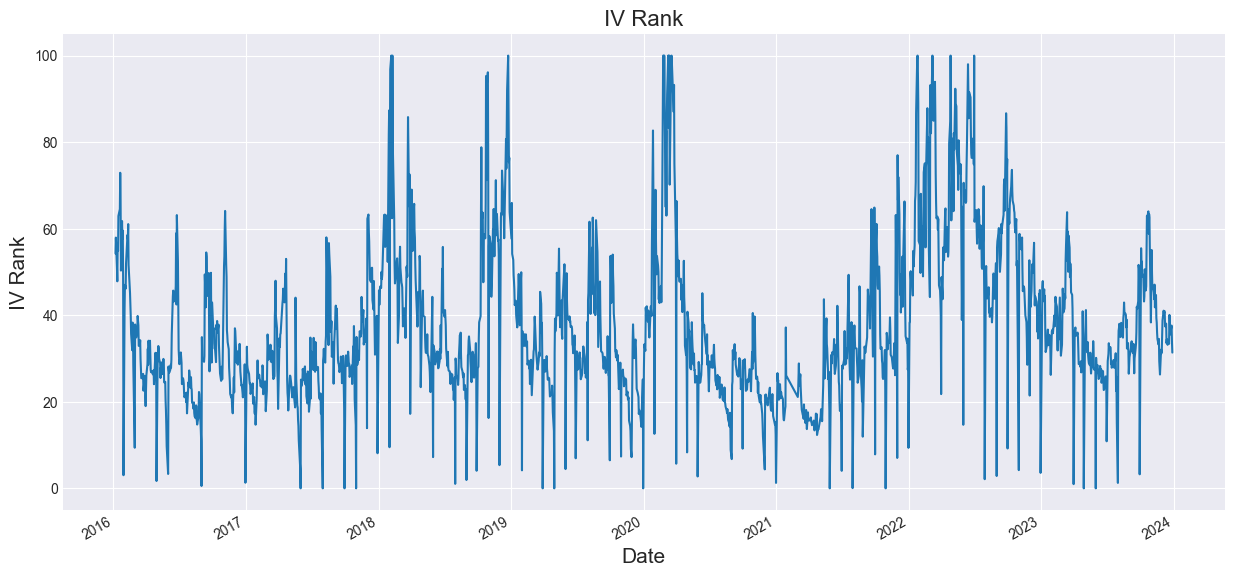

In [7]:
# Define a rolling window
rolling_window = 252

# Calculate rolling 252-day min and max for ATM IV
atm_data['Rolling_Min'] = atm_data['ATM_IV'].rolling(window=rolling_window, min_periods=252).min()
atm_data['Rolling_Max'] = atm_data['ATM_IV'].rolling(window=rolling_window, min_periods=252).max()

# Compute the IV Rank for each day
atm_data['IV_Rank'] = round(((atm_data['ATM_IV'] - atm_data['Rolling_Min']) / (atm_data['Rolling_Max'] - atm_data['Rolling_Min'])) * 100, 2)

# Drop the NaN values
atm_data.dropna(inplace=True)

# Plot the IV Rank
plt.figure(figsize=(15, 7))
atm_data['IV_Rank'].plot()
plt.title('IV Rank', fontsize=16)
plt.xlabel('Date', fontsize=15)
plt.ylabel('IV Rank', fontsize=15)
plt.show()

In [8]:
# Display the data
atm_data.tail()

,[STRIKE],[UNDERLYING_LAST],[C_IV],[P_IV],ATM,ATM_IV,Rolling_Min,Rolling_Max,IV_Rank
[QUOTE_DATE],,,,,,,,,
2023-12-21,4745.0,4747.03,0.10688,0.10432,4745.0,0.105600,0.00647,0.260015,39.10
2023-12-22,4755.0,4755.11,0.10457,0.08862,4755.0,0.096595,0.00647,0.260015,35.55
2023-12-26,4775.0,4774.94,0.11252,0.09116,4775.0,0.101840,0.00647,0.260015,37.61
2023-12-27,4780.0,4782.50,0.10527,0.07920,4780.0,0.092235,0.00647,0.260015,33.83
2023-12-28,4785.0,4783.83,0.09241,0.07958,4785.0,0.085995,0.00647,0.260015,31.37


<a id='conclusion'></a>
## Conclusion
In this notebook, we computed the IV rank for the ATM options. The IV rank of `39.10` on `2023-12-21` signifies that the current implied volatility is positioned in the lower 39.10% of its historical range over the last 252 trading days. We will use this information to trade volatility.<br><br>